## GB_FX Price only Monthly

Data (B): 2000-01-31 → 2025-11-10 | n=6726
Data (D): 2000-01-31 → 2025-11-10 | n=9416

Dropped months and reasons:
  2000-01: no_cut_in_prev_month
  2000-02: hist<40
  2000-03: hist<40

=== Model performance (monthly mean, EUR/NOK) ===
Observations: 308
RMSE (level): 0.153591
MAE  (level): 0.104060
Directional accuracy: 204/307 (66.4%)

=== Diebold–Mariano vs Random Walk ===
Loss: MSE | horizon h=1
DM-statistic: -1.5178
p-value     : 0.1291


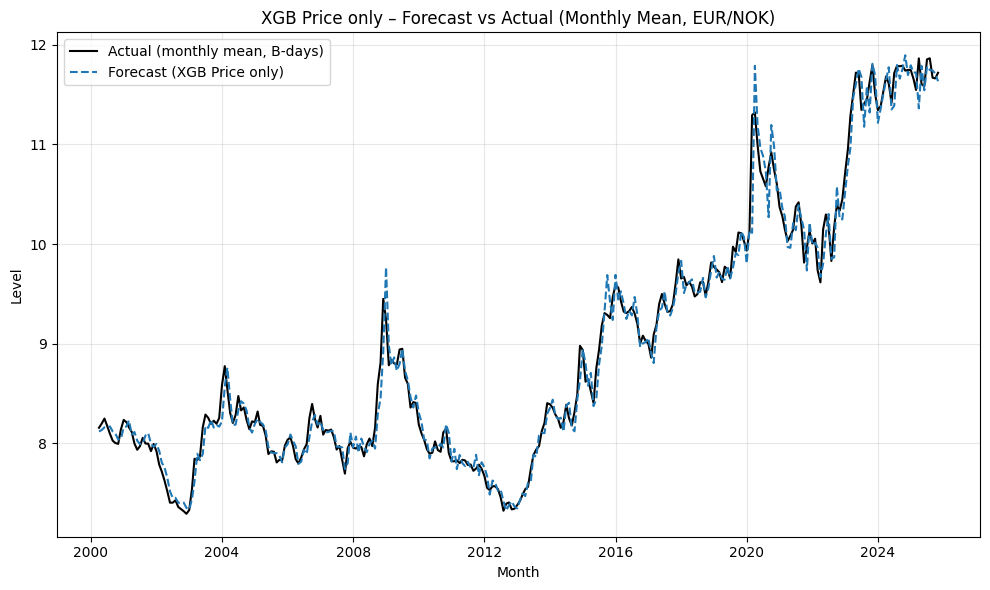

Saved PNG: XGB_PriceOnly.png


In [ ]:
# =========================================
# XGB Price only – EUR/NOK walk-forward (monthly, levels), point forecast only
# PARALLEL OUTER LOOP
# - Data: variables_daily.csv (daily wide), ONLY EUR_NOK column used
# - Forward-filled to daily calendar + business-day truth
# - Cut: last business day of previous month
# - Model: XGBRegressor on EUR_NOK daily lag features (one-step)
# - Forecast: recursive daily next-month -> aggregate to monthly mean over business days
# - Guard: max_horizon (drop months with H > max_horizon)
# - Constraint: n_estimators <= 150
# - History requirement MATCHES RW: min_hist_days=40 before each cut
# - Output: save ONLY PNG as "XGB_PriceOnly.png"
# =========================================

!pip -q install pandas numpy scikit-learn matplotlib requests certifi joblib xgboost

from __future__ import annotations
import io, time, math
from dataclasses import dataclass
from typing import Optional, Tuple, Dict

import numpy as np
import pandas as pd
import requests, certifi
import matplotlib.pyplot as plt

from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from joblib import Parallel, delayed


# -----------------------------
# Configuration
# -----------------------------
@dataclass
class Config:
    url: str = (
        "https://raw.githubusercontent.com/bredeespelid/"
        "Data_MasterOppgave/refs/heads/main/Variables/All_Variables/variables_daily.csv"
    )

    m_freq: str = "M"
    max_lags: int = 20
    max_horizon: int = 64

    # MATCH RW history rule
    min_hist_days: int = 40   # minimum daily history before cut

    # Tuned XGB hyperparameters (theta*)
    n_estimators: int = 150
    learning_rate: float = 0.04
    max_depth: int = 6
    min_child_weight: float = 7.0
    subsample: float = 0.6
    colsample_bytree: float = 1.0
    gamma: float = 0.05
    reg_alpha: float = 0.2
    reg_lambda: float = 0.5

    # Fixed model choices (not tuned)
    tree_method: str = "hist"
    objective: str = "reg:squarederror"
    eval_metric: str = "rmse"
    random_state: int = 42

    retries: int = 3
    timeout: int = 60
    verbose: bool = True

    fig_png: str = "XGB_PriceOnly.png"

CFG = Config()
TARGET_SERIES = "EUR_NOK"


# -----------------------------
# Download helper
# -----------------------------
def download_csv_text(url: str, retries: int, timeout: int) -> str:
    """Download CSV with simple retry/backoff."""
    last_err = None
    for k in range(1, retries + 1):
        try:
            r = requests.get(url, timeout=timeout, verify=certifi.where())
            r.raise_for_status()
            return r.text
        except Exception as e:
            last_err = e
            if k < retries:
                wait = 1.5 * k
                print(f"[warning] Download failed (try {k}/{retries}): {e}. Retrying in {wait:.1f}s ...")
                time.sleep(wait)
    raise RuntimeError(f"Download failed: {last_err}")


# -----------------------------
# Data loading (ONLY EUR_NOK)
# -----------------------------
def load_series(url: str) -> Tuple[pd.Series, pd.Series]:
    """
    Load variables_daily.csv, but only Date + EUR_NOK are used.

    Returns:
      S_b: EUR_NOK on business days (B), ffilled (truth/aggregation base)
      S_d: EUR_NOK on calendar days (D), ffilled (model inputs/recursion)
    """
    text = download_csv_text(url, CFG.retries, CFG.timeout)
    raw = pd.read_csv(io.StringIO(text))

    required = {"Date", TARGET_SERIES}
    missing = required - set(raw.columns)
    if missing:
        raise ValueError(f"Missing columns in CSV: {missing}. Got: {list(raw.columns)}")

    df = (
        raw[list(required)]
        .rename(columns={"Date": "DATE"})
        .assign(DATE=lambda x: pd.to_datetime(x["DATE"], errors="coerce"))
        .dropna(subset=["DATE", TARGET_SERIES])
        .sort_values("DATE")
        .set_index("DATE")
    )

    df[TARGET_SERIES] = pd.to_numeric(df[TARGET_SERIES], errors="coerce")
    df = df.dropna(subset=[TARGET_SERIES])

    if df.empty:
        raise ValueError("Dataset is empty after cleaning.")

    # Business-day series (truth/aggregation base)
    S_b = df[TARGET_SERIES].asfreq("B").ffill().astype(float)
    S_b.name = TARGET_SERIES

    # Daily calendar series (inputs/recursion)
    full_idx = pd.date_range(df.index.min(), df.index.max(), freq="D")
    S_d = df[TARGET_SERIES].reindex(full_idx).ffill().astype(float)
    S_d.index.name = "DATE"
    S_d.name = TARGET_SERIES

    return S_b, S_d


def last_trading_day(S_b: pd.Series, start: pd.Timestamp, end: pd.Timestamp) -> Optional[pd.Timestamp]:
    """Return the last business day in [start, end]."""
    sl = S_b.loc[start:end]
    return sl.index[-1] if not sl.empty else None


# -----------------------------
# Feature engineering (lags)
# -----------------------------
def make_lag_matrix(y: pd.Series, max_lags: int) -> Tuple[np.ndarray, np.ndarray]:
    """One-step daily lag matrix for EUR_NOK."""
    df = pd.DataFrame({"y": y})
    for k in range(1, max_lags + 1):
        df[f"lag{k}"] = df["y"].shift(k)
    df = df.dropna()

    X = df[[f"lag{k}" for k in range(1, max_lags + 1)]].values
    y_target = df["y"].values
    return X, y_target


# -----------------------------
# XGBoost one-step (NO validation split)
# -----------------------------
def fit_xgb_one_step(y_hist_daily: pd.Series) -> XGBRegressor:
    """Fit XGB for one-step ahead daily prediction, capped at 150 trees."""
    X, y_target = make_lag_matrix(y_hist_daily, CFG.max_lags)

    if len(X) < 5:
        raise ValueError("Too few observations after lagging to fit model.")

    model = XGBRegressor(
        n_estimators=CFG.n_estimators,
        learning_rate=CFG.learning_rate,
        max_depth=CFG.max_depth,
        min_child_weight=CFG.min_child_weight,
        subsample=CFG.subsample,
        colsample_bytree=CFG.colsample_bytree,
        gamma=CFG.gamma,
        reg_alpha=CFG.reg_alpha,
        reg_lambda=CFG.reg_lambda,
        objective=CFG.objective,
        eval_metric=CFG.eval_metric,
        tree_method=CFG.tree_method,
        random_state=CFG.random_state,
        n_jobs=1
    )
    model.fit(X, y_target)
    return model


def recursive_daily_forecast(model: XGBRegressor, y_hist_daily: pd.Series, H: int) -> pd.Series:
    """Recursive EUR_NOK daily forecasts for H days."""
    hist = y_hist_daily.values.tolist()
    preds = []

    for _ in range(H):
        if len(hist) < CFG.max_lags:
            raise ValueError("Not enough history for lag features.")

        x = np.array(hist[-CFG.max_lags:][::-1], dtype=float).reshape(1, -1)
        yhat = float(model.predict(x)[0])
        preds.append(yhat)
        hist.append(yhat)

    return pd.Series(preds)


# -----------------------------
# Monthly walk-forward (parallel)
# -----------------------------
def walk_forward_xgb_monthly_parallel(
    S_b: pd.Series,
    S_d: pd.Series,
    n_jobs_outer: int = -1
) -> pd.DataFrame:
    """Monthly walk-forward with XGB on EUR_NOK only, with max_horizon guard."""
    first_m = pd.Period(S_b.index.min(), freq=CFG.m_freq)
    last_m  = pd.Period(S_b.index.max(), freq=CFG.m_freq)
    months = pd.period_range(first_m, last_m, freq=CFG.m_freq)

    def _process_one_month(m: pd.Period):
        prev_m = m - 1
        m_start, m_end = m.start_time, m.end_time
        prev_start, prev_end = prev_m.start_time, prev_m.end_time

        cut = last_trading_day(S_b, prev_start, prev_end)
        if cut is None:
            return (str(m), None, "no_cut_in_prev_month")

        hist_d = S_d.loc[:cut]

        # MATCH RW history requirement (calendar-day series)
        if hist_d.size < CFG.min_hist_days:
            return (str(m), None, f"hist<{CFG.min_hist_days}")

        # still ensure enough for lagging
        if hist_d.size <= CFG.max_lags:
            return (str(m), None, "hist<=max_lags")

        # Business days in target month
        idx_m_b = S_b.index[(S_b.index >= m_start) & (S_b.index <= m_end)]
        if idx_m_b.size < 1:
            return (str(m), None, "no_bdays_in_month")
        y_true = float(S_b.loc[idx_m_b].mean())

        # Horizon = full calendar month length
        H = (m_end.date() - m_start.date()).days + 1
        if H <= 0 or H > CFG.max_horizon:
            return (str(m), None, f"horizon_invalid(H={H})")

        model = fit_xgb_one_step(hist_d)
        pf = recursive_daily_forecast(model, hist_d, H)

        f_idx = pd.date_range(cut + pd.Timedelta(days=1), periods=H, freq="D")
        pred_daily = pd.Series(pf.values, index=f_idx, name="point")

        # Aggregate to business-day mean
        pred_b = pred_daily.reindex(idx_m_b, method=None)
        if pred_b.isna().all():
            return (str(m), None, "no_overlap_pred_B_days")
        y_pred = float(pred_b.dropna().mean())

        row = {"month": m, "cut": cut, "y_true": y_true, "y_pred": y_pred}
        return (str(m), row, None)

    results = Parallel(n_jobs=n_jobs_outer, backend="loky")(
        delayed(_process_one_month)(m) for m in months
    )

    rows: Dict[str, dict] = {}
    dropped: Dict[str, str] = {}

    for key, row, reason in results:
        if row is not None:
            rows[key] = row
        else:
            dropped[key] = reason or "unknown"

    df = pd.DataFrame.from_dict(rows, orient="index")
    if not df.empty:
        df = df.set_index("month").sort_index()

    if CFG.verbose and dropped:
        miss = [str(m) for m in months if str(m) not in rows]
        if miss:
            print("\nDropped months and reasons:")
            for mm in miss:
                print(f"  {mm}: {dropped.get(mm, 'unknown')}")

    return df


# -----------------------------
# Evaluation (level + direction)
# -----------------------------
def evaluate(eval_df: pd.DataFrame) -> pd.DataFrame:
    df = eval_df.copy()
    df["err"] = df["y_true"] - df["y_pred"]
    core = df.dropna(subset=["y_true", "y_pred"]).copy()

    n_obs = int(len(core))
    rmse = float(np.sqrt(np.mean(np.square(core["err"])))) if n_obs else np.nan
    mae  = float(mean_absolute_error(core["y_true"], core["y_pred"])) if n_obs else np.nan

    core["y_prev"] = core["y_true"].shift(1)
    mask = core["y_prev"].notna()
    dir_true = np.sign(core.loc[mask, "y_true"] - core.loc[mask, "y_prev"])
    dir_pred = np.sign(core.loc[mask, "y_pred"] - core.loc[mask, "y_prev"])
    hits = int((dir_true.values == dir_pred.values).sum())
    total = int(mask.sum())
    hit_rate = (hits / total) if total else np.nan

    print("\n=== Model performance (monthly mean, EUR/NOK) ===")
    print(f"Observations: {n_obs}")
    print(f"RMSE (level): {rmse:.6f}")
    print(f"MAE  (level): {mae:.6f}")
    if total:
        print(f"Directional accuracy: {hits}/{total} ({hit_rate*100:.1f}%)")

    return core


# -----------------------------
# Diebold–Mariano (vs RW)
# -----------------------------
def _normal_cdf(z: float) -> float:
    return 0.5 * (1.0 + math.erf(z / math.sqrt(2.0)))

def dm_test(
    y_true: pd.Series,
    y_model: pd.Series,
    y_rw: pd.Series,
    h: int = 1,
    loss: str = "mse"
):
    df = pd.concat({"y": y_true, "m": y_model, "rw": y_rw}, axis=1).dropna()
    if df.empty or len(df) < 5:
        return float("nan"), float("nan")

    e_m = df["y"] - df["m"]
    e_r = df["y"] - df["rw"]
    d = np.abs(e_m) - np.abs(e_r) if loss.lower() == "mae" else (e_m**2) - (e_r**2)

    N = int(len(d))
    d_mean = float(d.mean())
    gamma0 = float(np.var(d, ddof=1)) if N > 1 else 0.0
    var_bar = gamma0 / N

    if h > 1 and N > 2:
        for k in range(1, min(h - 1, N - 1) + 1):
            w_k = 1.0 - k / h
            cov_k = float(np.cov(d[k:], d[:-k], ddof=1)[0, 1])
            var_bar += 2.0 * w_k * cov_k / N

    if var_bar <= 0 or not np.isfinite(var_bar):
        return float("nan"), float("nan")

    dm_stat = d_mean / math.sqrt(var_bar)
    p_val = 2.0 * (1.0 - _normal_cdf(abs(dm_stat)))
    return dm_stat, p_val

def dm_against_random_walk(eval_df: pd.DataFrame, loss: str = "mse", h: int = 1):
    df = eval_df.copy()
    df["rw_pred"] = df["y_true"].shift(1)
    dm_stat, p_val = dm_test(df["y_true"], df["y_pred"], df["rw_pred"], h=h, loss=loss)
    print("\n=== Diebold–Mariano vs Random Walk ===")
    print(f"Loss: {loss.upper()} | horizon h={h}")
    print(f"DM-statistic: {dm_stat:.4f}" if np.isfinite(dm_stat) else "DM-statistic: nan")
    print(f"p-value     : {p_val:.4f}" if np.isfinite(p_val) else "p-value     : nan")


# -----------------------------
# Plot (PNG only)
# -----------------------------
def plot_monthly_simple(eval_df: pd.DataFrame, png_path: str):
    if eval_df.empty:
        print("Nothing to plot.")
        return

    plt.figure(figsize=(10, 6))
    x = eval_df.index.to_timestamp() if isinstance(eval_df.index, pd.PeriodIndex) else eval_df.index

    plt.plot(x, eval_df["y_true"], color="black", label="Actual (monthly mean, B-days)")
    plt.plot(x, eval_df["y_pred"], color="tab:blue", linestyle="--", label="Forecast (XGB Price only)")

    plt.title("XGB Price only – Forecast vs Actual (Monthly Mean, EUR/NOK)")
    plt.xlabel("Month")
    plt.ylabel("Level")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    plt.savefig(png_path, dpi=300, bbox_inches="tight")
    plt.show()
    print(f"Saved PNG: {png_path}")


# -----------------------------
# Main
# -----------------------------
def main():
    S_b, S_d = load_series(CFG.url)
    if CFG.verbose:
        print(f"Data (B): {S_b.index.min().date()} → {S_b.index.max().date()} | n={len(S_b)}")
        print(f"Data (D): {S_d.index.min().date()} → {S_d.index.max().date()} | n={len(S_d)}")

    df_eval = walk_forward_xgb_monthly_parallel(S_b, S_d, n_jobs_outer=-1)
    eval_df = evaluate(df_eval)

    dm_against_random_walk(eval_df, loss="mse", h=1)
    plot_monthly_simple(eval_df, CFG.fig_png)

if __name__ == "__main__":
    main()
